In [24]:
"""
CNN that aims to classify MNIST dataset accurately.
Learns low-level features of images using convolutional layers.
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# Load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
input_shape = (28, 28, 1) # 28*28 pixels, 1 channel
num_classes = 10

# Normalize inputs
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# Add channel (only 1) to input shape (to pass into Conv2D) so inputs have 4 dimensions
X_train = X_train.reshape((len(X_train), input_shape[0], input_shape[1], input_shape[2]))
X_test = X_test.reshape((len(X_test), input_shape[0], input_shape[1], input_shape[2]))
# Encode target labels via one-hot-encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# Build model and add layers
model = Sequential([
    Conv2D(16, (3,3), input_shape=input_shape, activation='relu', name='conv1'), # shape=(26,26,16)
    BatchNormalization(name='norm2'),
    MaxPool2D((2,2), name='pool3'), # shape=(13,13,16)
    Conv2D(32, (3,3), activation='relu', name='conv4'), # shape=(11,11,32)
    BatchNormalization(name='norm5'),
    MaxPool2D((2,2), name='pool6'), # shape=(5,5,32)
    Flatten(name='flatten7'),
    Dense(256, name='dense8'),
    BatchNormalization(name='norm9'),
    Activation('sigmoid', name='act10'),
    Dropout(0.2, name='drop11'),
    Dense(64, name='dense12'),
    Activation('tanh', name='act13'),
    Dense(num_classes, name='dense14'), # output layer
    Activation('softmax', name='act15')
], name='cnn0')
print(model.summary())


# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
hist = model.fit(X_train, y_train, batch_size=100, epochs=100, 
                 callbacks=[reduce_lr, early_stopping], 
                 validation_data=(X_test, y_test))


# Use model to predict target labels
y_probs = model.predict(X_test) # array of probabilities for each class for each sample
# Select highest probability as predicted y value
y_hat = np.argmax(y_probs, axis=1) # predicted class labels
y = np.argmax(y_test, axis=1) # actual class labels


Model: "cnn0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 16)        160       
_________________________________________________________________
norm2 (BatchNormalization)   (None, 26, 26, 16)        64        
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 13, 13, 16)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 11, 11, 32)        4640      
_________________________________________________________________
norm5 (BatchNormalization)   (None, 11, 11, 32)        128       
_________________________________________________________________
pool6 (MaxPooling2D)         (None, 5, 5, 32)          0         
_________________________________________________________________
flatten7 (Flatten)           (None, 800)               0      

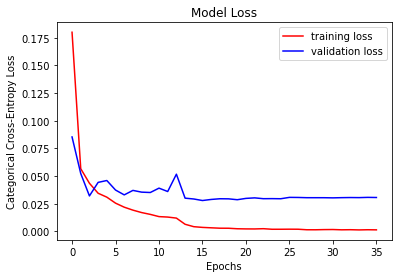

Confusion Matrix: (x: true class, y: predicted class)
 [[ 978    1    0    0    0    0    1    0    0    0]
 [   0 1131    1    1    0    0    0    1    1    0]
 [   1    1 1022    1    0    0    0    5    2    0]
 [   0    0    0 1005    0    4    0    0    1    0]
 [   0    0    0    0  976    0    0    0    1    5]
 [   1    0    0    5    0  884    1    1    0    0]
 [   2    1    0    0    1    2  951    0    1    0]
 [   0    2    4    0    0    0    0 1020    1    1]
 [   2    0    2    0    0    1    0    1  967    1]
 [   1    1    0    0    6    0    0    2    3  996]]
Balanced Acccuracy Score: 0.9929556055125695


In [56]:
""" Results Analysis """
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

# Plot loss function
plt.plot(hist.history['loss'], label='training loss', color='#ff0000')
plt.plot(hist.history['val_loss'], label='validation loss', color='#0000ff')
plt.title('Model Loss')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# Classification metrics
cm = confusion_matrix(y, y_hat)
print("Confusion Matrix: (x: true class, y: predicted class)\n", cm)

bac = balanced_accuracy_score(y, y_hat)
print("Balanced Acccuracy Score:", bac)
